# 2. Getting started

## Introducing the GeLaTo library

From now on, we shall use the Python library [spl](https://github.com/pyccel/spl). 

Let us consider the following weak formulation

$$\int_{\Omega} N_i N_j + \nabla N_i \cdot \nabla N_j ~d\Omega$$

In the case where $\Omega$ is the unit cube, we should expect the GLT symbol

$$
\mathfrak{m}_p(\theta_1) \mathfrak{m}_p(\theta_2) \mathfrak{m}_p(\theta_3) + \mathfrak{m}_p(\theta_1) \mathfrak{m}_p(\theta_2) \mathfrak{s}_p(\theta_3) + \mathfrak{m}_p(\theta_1) \mathfrak{s}_p(\theta_2) \mathfrak{m}_p(\theta_3) + \mathfrak{s}_p(\theta_1) \mathfrak{m}_p(\theta_2) \mathfrak{m}_p(\theta_3)
$$

In [2]:
# ... some imports
from numpy import linspace, zeros, pi

from sympy.core.containers import Tuple
from sympy import symbols
from sympy import Symbol
from sympy import Lambda
from sympy import IndexedBase

from gelato.glt import glt_symbol
from gelato.calculus   import (Dot, Cross, Grad, Curl, Rot, Div)
from gelato.fem.utils    import compile_symbol

from spl.fem.splines import SplineSpace
from spl.fem.tensor  import TensorSpace

We define our weak formulation using

In [3]:
x,y,z = symbols('x y z')

u = Symbol('u')
v = Symbol('v')

a = Lambda((x,y,z,v,u), Dot(Grad(u), Grad(v)))

The GLT symbol can then be computed by giving a discretization

In [4]:

# ...  create a finite element space
p1  = 3 ; p2  = 3 ; p3  = 3
ne1 = 16 ; ne2 = 16 ; ne3 = 16

grid_1 = linspace(0., 1., ne1+1)
grid_2 = linspace(0., 1., ne2+1)
grid_3 = linspace(0., 1., ne3+1)

V1 = SplineSpace(p1, grid=grid_1)
V2 = SplineSpace(p2, grid=grid_2)
V3 = SplineSpace(p3, grid=grid_3)

V = TensorSpace(V1, V2, V3)
# ...

# ... create a glt symbol from a string without evaluation
symbol = glt_symbol(a, space=V)
# ...

We get a *sympy* expression, that we can manipulate like any other *sympy*
expression. Let's print it

In [5]:
print (symbol)

m1*m2*s3 + m1*m3*s2 + m2*m3*s1


Good, but that's not readable for a human. You can now convert this expression to latex using

In [6]:
from IPython.display import Math
from sympy import latex

Math(latex(symbol))

<IPython.core.display.Math object>

For pretty printing, you may use the **glt_latex** function

In [7]:
from gelato.printing.latex import glt_latex

Math(glt_latex(symbol))

<IPython.core.display.Math object>

Let's now **evaluate** our symbol (in the symbolic sens) in order to do some diagnostics

In [8]:
symbol = glt_symbol(a, space=V, evaluate=True)

In [9]:
Math(glt_latex(symbol.expr))

<IPython.core.display.Math object>

We recall that the eigenvalues of the matrix associated to our weak formulation can be *approximated* by a *uniform sampling* of the symbol

In [10]:
# ... make the symbol a callable function, that can be evaluated numericaly
symbol_f90 = compile_symbol('symbol_3d', a, V, backend='fortran')
# ...

In [11]:
# ... example of symbol evaluation
t1 = linspace(-pi,pi, ne1+1)
t2 = linspace(-pi,pi, ne2+1)
t3 = linspace(-pi,pi, ne3+1)
x1 = linspace(0.,1., ne1+1)
x2 = linspace(0.,1., ne2+1)
x3 = linspace(0.,1., ne3+1)
eig = zeros((ne1+1, ne2+1, ne3+1), order='F')
symbol_f90(x1,x2,x3,t1,t2,t3, eig)
# ...

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

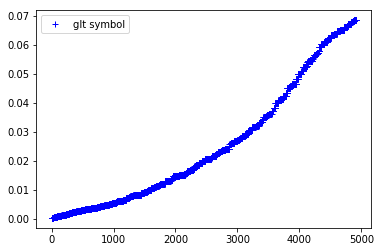

In [13]:
t = eig.ravel()
t.sort()
plt.plot(t, "+b", label="glt symbol")
plt.legend(loc=2);

## Using SPL and GeLaTo

In this section, we show how to use both [GeLaTo](https://github.com/pyccel/GeLaTo) and [spl](https://github.com/pyccel/spl) in order to assemble a weak-formulation and study its spectral properties.

We start by the Laplace operator in **1D**. As in the previous section, we define its weak formulation using the **lambda** expression

In [14]:
# ... define the weak formulation
x = Symbol('x')

u = Symbol('u')
v = Symbol('v')

expr = Lambda((x,v,u), Dot(Grad(u), Grad(v)) + u*v)
# ...

In [15]:
# needed imports
from numpy import linspace
from spl.fem.splines import SplineSpace
from gelato.fem.assembly import assemble_matrix
from gelato.fem.utils    import compile_kernel

In [16]:
# ...  create a finite element space
p  = 3
ne = 64

grid = linspace(0., 1., ne+1)

V = SplineSpace(p, grid=grid)
# ...

*GeLaTo* has a nice function **compile_kernel**, that constructs the FEM assembly kernel, given a weak formulation. You can call it this way:

In [17]:
kernel_py = compile_kernel('kernel_1', a, V)

You can now assemble the corresponding matrix, using:

In [18]:
M_py  = assemble_matrix(V, kernel_py).tocsr()

The **compile_kernel** function has a **backend** argument which is used to decide the target language (*Python/Fortran*) for the kernel. The available choices are *'python'* or *'fortran'*. For *Fortran*, you can call it this way:

In [19]:
kernel_f90 = compile_kernel('kernel_1', a, V, backend='fortran')
M_f90 = assemble_matrix(V, kernel_f90).tocsr()

Now, we convert the sparse matrix to a dense one, in order to use lapack eigenvalue solver.

In [20]:
M = M_f90.todense()

In [21]:
# import eigenvalue solver
from scipy.linalg import eig

w, v = eig(M)
wr = w.real
wr.sort()

In [22]:
# compile the glt symbol to get a callable function that can be evaluated
symbol_f90 = compile_symbol('symbol_1d', a, V, backend='fortran')

In [23]:
# example of symbol evaluation
t1 = linspace(-pi,pi, ne+1)
x1 = linspace(0.,1., ne+1)
e = zeros(ne+1)
symbol_f90(x1, t1, e)
e.sort()

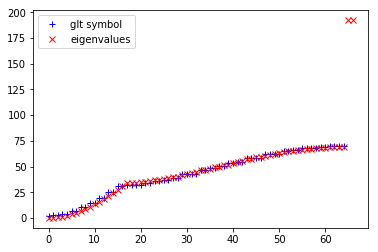

In [24]:
plt.plot(e, "+b", label="glt symbol")
plt.plot(wr, "xr", label="eigenvalues")
plt.legend(loc=2);

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()